In Part-I, we introduced a transfer learning model for Intel Image Data set. In this notebook, we will build and train a CNN architecture from scratch. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
#import torchvision.transforms as transforms
from torchvision import datasets, transforms, models

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import SubsetRandomSampler
from torch._six import int_classes as _int_classes
from tensorboardX import SummaryWriter
from IPython.display import display, clear_output
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
pd.set_option('precision', 4)
import time
from itertools import product
from collections import namedtuple
from collections import OrderedDict
import datetime
import warnings
warnings.filterwarnings('ignore')
from torchsummary import summary
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
data_dir='~/MyDnnLibrary/Data/IntelImage'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

raw_dir = data_dir + '/raw'

In [3]:
# Define transforms for the training, validation, and testing sets. Especially resizing is very important.
training_transforms = transforms.Compose([transforms.Resize(size = (150,150)),
                                          transforms.RandomRotation(30),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomVerticalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])]
                                            )

test_transforms = transforms.Compose([transforms.Resize(size = (150,150)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])]
                                    )



train_set = datasets.ImageFolder(train_dir, transform=training_transforms)
test_set = datasets.ImageFolder(test_dir, transform=test_transforms)

In [4]:
#whenver possible use GPU!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# The idea is to use torch.nn features. Use super() function.
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=256,kernel_size=5)
        self.bn1 = nn.BatchNorm2d(256)
        
        self.conv2 = nn.Conv2d(in_channels=256,out_channels=128,kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=5)
        self.bn3 = nn.BatchNorm2d(64)
        
    
        self.fc1 = nn.Linear(in_features=64*3*3,out_features=4000)
        self.bn5 = nn.BatchNorm1d(4000)
        self.drop1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(in_features=4000,out_features=4000)
        self.bn6 = nn.BatchNorm1d(4000)
        self.drop2 = nn.Dropout(0.6)
        
        self.fc3 = nn.Linear(in_features=4000,out_features=1000)
        self.bn7 = nn.BatchNorm1d(1000)
        self.out = nn.Linear(in_features=1000,out_features=6)
        
    def forward(self, t):
        t = F.relu(self.bn1(self.conv1(t)))
        t = F.avg_pool2d(t,kernel_size=3,stride=3)
        
        t = F.relu(self.bn2(self.conv2(t)))
        t = F.avg_pool2d(t,kernel_size=3,stride=3)
        
        t = F.relu(self.bn3(self.conv3(t)))
        t =  F.avg_pool2d(t,kernel_size=3,stride=3)        
        
        
        t = t.reshape(-1,64*3*3)
        
        t = F.relu(self.bn5(self.fc1(t)))
        t = self.drop1(t)
    
        
        t = F.relu(self.bn6(self.fc2(t)))
        t = self.drop2(t)
        
        t = F.relu(self.bn7(self.fc3(t)))
        
        t = self.out(t)
        t =  F.log_softmax(t,dim=1)
        return t

The architecture above shows the final state of the model. Initially, we have 64,32,16 feature maps in the convolution layers followed by 2dbatch norms and 16x3x3=144,4000,4000,1000,6 neurons in the linear layers without any droput. Initial configuration can be seen below. In this work, the main algorithm saves the best model after we go over %80. To ease the work flow, we prefer not to display all coloumns but the best results achieved. However we can look at the entire outputs anytime since we write them to a csv file. 

In [6]:
#initial model
network = Network().to('cuda')
summary(network, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 146, 146]           4,864
       BatchNorm2d-2         [-1, 64, 146, 146]             128
            Conv2d-3           [-1, 32, 44, 44]          51,232
       BatchNorm2d-4           [-1, 32, 44, 44]              64
            Conv2d-5           [-1, 16, 10, 10]          12,816
       BatchNorm2d-6           [-1, 16, 10, 10]              32
            Linear-7                 [-1, 4000]         580,000
       BatchNorm1d-8                 [-1, 4000]           8,000
           Dropout-9                 [-1, 4000]               0
           Linear-10                 [-1, 4000]      16,004,000
      BatchNorm1d-11                 [-1, 4000]           8,000
          Dropout-12                 [-1, 4000]               0
           Linear-13                 [-1, 1000]       4,001,000
      BatchNorm1d-14                 [-

In [8]:
def TrainTime(run_count,epoch,num_epochs, epoc_duration, runtotal):
    #get some time statistics in the training.
    total_min = num_epochs*runtotal*epoc_duration/60
    total_hour = total_min/60
    rem_min = ((runtotal-run_count+1)*num_epochs - epoch)*epoc_duration/60
    rem_hour = rem_min/60
    print("Aproximate Training time: {m:2.2f} mins / {h:2.2f} hours \
          Approximate Remaining Time: {rm:2.2f} mins / {rh:2.2f} hours".format(m=total_min, h=total_hour,rm=rem_min,rh=rem_hour))
    
def GetFilename(name='CNN'):
    #create uniqe filenames to label various statistics.
    now = datetime.datetime.now()
    now = str(now.strftime("%Y-%m-%d %H:%M"))
    now = name+now.replace(' ', '_time_').replace(':', '-')
    return now

def GetBestAcc(filename,n):
    #get the best n accuracy of the cuurent experiment.
    df = pd.read_csv(filename)
    sort_by_test_accuracy = df.sort_values('TestAccuracy',ascending=False)
    display(sort_by_test_accuracy.head(n=n))
    
def GetBestStats(FinalResults,HyperParameters):
    #tags for the final models for further inference.
    df = pd.read_csv(FinalResults,float_precision='0.2f')
    best = {'max_epoch_num':      df['epoch'].max(),
            'BestTrainLoss':      df['TrainLoss'].min(),
            'BestTrainAccuracy':  df['TrainAccuracy'].max(),
            'BestTestLoss':       df['TestLoss'].min(),
            'BestTestAccuracy':   df['TestAccuracy'].max(),
            'lr':                 HyperParameters['lr'][0],
            'batch_size':         HyperParameters['batch_size'][0],
            'weight_decay':       HyperParameters['weight_decay'][0]
           }
    return best

In [68]:
def save_checkpoint(model,name,final_results):
    # saves the model with the given info. results must be provided as csv.
    beststats = GetBestStats(final_results,HyperParameters)
    
    model.class_to_idx = train_set.class_to_idx
    checkpoint = {'arch': model,
                 'class_to_idx': model.class_to_idx,
                 'state_dict': model.state_dict(),
                }
    checkpoint.update({'BestScores':beststats})

    torch.save(checkpoint, name+'.pth')

In [69]:
def load_checkpoint(filepath):
    #load the model and return in eval() mode.
    checkpoint = torch.load(filepath)
    model = checkpoint['arch']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['BestScores']
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model


In [85]:
def StartTrain(num_epochs, runtotal):
    max_acc=0.80
    run_count = 0
    df = pd.DataFrame(columns=['run', 'epoch', 'TrainLoss','TrainAccuracy','TestLoss','TestAccuracy',
                             'lr','batch_size','weight_decay','epoch_duration'])
    for lr, batch_size, weight_decay in product(*param_values):
        run_count += 1
        
        torch.cuda.empty_cache()
        
        #model = Network().to(device) # if custom CNN used
       
        ###
        model.to(device) #if pretrained model used
        for parameter in model.parameters():
            parameter.requires_grad = True
        ###
        
        train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True )
        test_loader = DataLoader(test_set,batch_size=batch_size)

        optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay,)
        
        
        # This works well with logsoftmax.
        criterion = nn.NLLLoss()

        # Crete tensorboard runs for visualize
        comment = f'batch_size={batch_size} lr={lr} weight_decay={weight_decay}' 
        tb = SummaryWriter(log_dir = 'runs/'+ GetFilename(),comment=comment)
        
        #sent some images if needed. 
#         images,labels = next(iter(train_loader))
#         images = images.to(device)
#         labels = labels.to(device)
#         grid = torchvision.utils.make_grid(images)
#         tb.add_image('images',grid)
#         tb.add_graph(model,images)

        for epoch in range(num_epochs):
            epoch_start = time.time()
            # set to train mode
            model.train()

            # compute the train loss and correct predictions per epoch
            train_loss = 0.0
            total_train_correct = 0

            # compute the test loss and correct predictions per epoch
            test_loss = 0.0
            total_test_correct = 0

            for i,(images, labels) in enumerate(train_loader):

                images = images.to(device)
                labels = labels.to(device)

                #In default, pytorch accumulates the gradient, zero out before each backpropagation.
                optimizer.zero_grad()

                # forward pass
                outputs = model(images)

                # compute the loss
                loss = criterion(outputs, labels)

                # backpropagate the gradients
                loss.backward()

                # update the parameters
                optimizer.step()

                # compute the total loss for the batch and add it to train_loss
                train_loss += loss.item() * images.size(0)

                # compute the predictions
                predictions = outputs.argmax(dim=1)

                # boolen compare the predictions vs labels and create the correct count tensor
                correct_counts = predictions.eq(labels)

                # convert the cuda tensor to FloatTensor and compute the mean for the batch
                acc = torch.mean(correct_counts.type(torch.FloatTensor)) 

                # accumulate the total train correct and update over the batches.
                total_train_correct += acc.item() * images.size(0) 
                #torch.cuda.empty_cache()


            # For testing, no need to track gradients.     
            with torch.no_grad():

                # set to evaluation mode
                model.eval()


                for j,(images, labels) in enumerate(test_loader):
                    images = images.to(device)
                    labels = labels.to(device)

                     # forward pass
                    outputs = model(images)

                    # compute the loss
                    loss = criterion(outputs, labels)

                    # compute the loss for the batch and add it to total test_loss
                    test_loss += loss.item() * images.size(0)

                    # compute the predictions
                    predictions = outputs.argmax(dim=1)

                    # boolen compare the predictions vs labels and create the correct count tensor
                    correct_counts = predictions.eq(labels)

                    # convert the cuda tensor to FloatTensor and compute the mean for the batch
                    acc = torch.mean(correct_counts.type(torch.FloatTensor))

                    # accumulate the total train correct and update over the batches.
                    total_test_correct += acc.item() * images.size(0)

                    
                    torch.cuda.empty_cache()

            # training loss and training accuracy
            avg_train_loss = train_loss/len(train_set) 
            avg_train_acc = total_train_correct/float(len(train_set))

            # test loss and test accuracy
            avg_test_loss = test_loss/len(test_set) 
            avg_test_acc = total_test_correct/float(len(test_set))


            epoch_end = time.time()

           #may want to check the computing performance.
            epoch_duration = epoch_end-epoch_start

            #tensorboard scaler variables
            tb.add_scalar('Traing_Loss', avg_train_loss,epoch)
            tb.add_scalar('Train_Accuracy',avg_train_acc,epoch)
            tb.add_scalar('Test_Loss',avg_test_loss,epoch)
            tb.add_scalar('Test_Accuracy',avg_test_acc,epoch)

            #print progress
            clear_output(wait=True)
            TrainTime(run_count,epoch,num_epochs, epoch_duration, runtotal)
            df.loc[int(num_epochs*(run_count-1)+epoch)] = [run_count, epoch+1, avg_train_loss ,avg_train_acc,
                                                     avg_test_loss,avg_test_acc,
                                               lr,batch_size,weight_decay,epoch_duration]
            df.to_csv(filename,index=False)
            display(df)
            
            if avg_test_acc > max_acc:
                
                opt_model = model
                max_acc = avg_test_acc  
    
    return opt_model
                

Step1 

- Lets start with the following hyper paramaters. As usual, we will then narrow down the search.

In [51]:
HyperParameters = dict(
    lr = [3e-2,3e-3,3e-4,3e-5],
    batch_size = [16,32, 64],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=7 ,runtotal=9)

In [8]:
results = 'TransferNew_2019-08-18_time_03-53.csv'
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLost,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
62,9.0,7.0,0.6977,0.7403,0.6724,0.7513,3.0000e-04,64.0,0.0,32.8764
47,7.0,6.0,0.8154,0.6968,0.6793,0.7480,3.0000e-04,16.0,0.0,36.4432
61,9.0,6.0,0.7124,0.7361,0.6779,0.7447,3.0000e-04,64.0,0.0,32.9480
75,11.0,6.0,0.7778,0.7080,0.6971,0.7443,3.0000e-05,32.0,0.0,33.9127
52,8.0,4.0,0.8104,0.6945,0.7025,0.7403,3.0000e-04,32.0,0.0,34.2977


Lets train more with lr=3e-4,3e-5 with bs=16,64,32

In [9]:
HyperParameters = dict(
    lr = [3e-4,3e-5],
    batch_size = [16,32, 64],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=20 ,runtotal=6)

In [5]:
results = 'TransferNew_2019-08-18_time_05-02.csv'
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLost,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
59,3.0,20.0,0.5150,0.8098,0.5162,0.8173,0.0003,64.0,0.0,31.6609
56,3.0,17.0,0.5490,0.7969,0.5305,0.8097,0.0003,64.0,0.0,32.0725
38,2.0,19.0,0.5610,0.7932,0.5323,0.8063,0.0003,32.0,0.0,32.8964
57,3.0,18.0,0.5325,0.8065,0.5357,0.8033,0.0003,64.0,0.0,31.7639
36,2.0,17.0,0.5739,0.7889,0.5372,0.8013,0.0003,32.0,0.0,34.0227


From the chart above, we can narrow down the search to lr = 3e-4 with batch size=32 and 64. Lets train 30 epochs on these paramaters and anaylze the results.

In [10]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32, 64],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=30 ,runtotal=2)

The best accuracy results indicate that we can work on lr=32.

In [6]:
results = 'TransferNew_2019-08-18_time_07-14.csv'
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLost,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
25,1.0,26.0,0.5017,0.8139,0.4756,0.8290,0.0003,32.0,0.0,30.3521
26,1.0,27.0,0.4976,0.8156,0.5040,0.8227,0.0003,32.0,0.0,30.1054
23,1.0,24.0,0.5203,0.8109,0.5094,0.8207,0.0003,32.0,0.0,30.2650
27,1.0,28.0,0.4855,0.8205,0.4992,0.8160,0.0003,32.0,0.0,30.2914
20,1.0,21.0,0.5363,0.8000,0.5186,0.8103,0.0003,32.0,0.0,30.3274


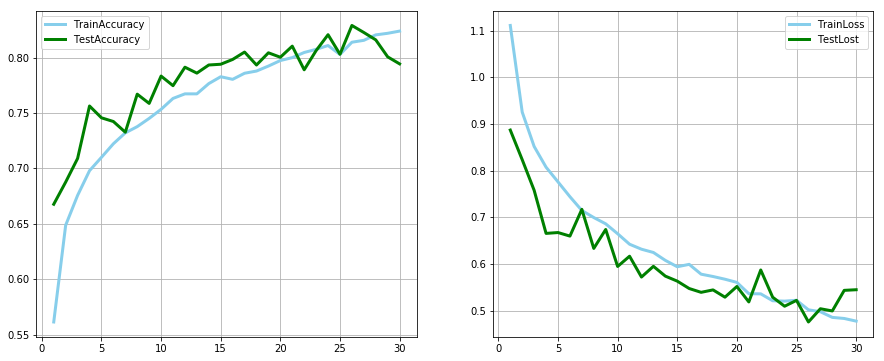

In [20]:
df = pd.read_csv('TransferNew_2019-08-18_time_07-14.csv')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.grid(True)
plt.plot( 'epoch', 'TrainAccuracy', data=df[:30], marker='',color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestAccuracy', data=df[:30], marker='', color='green', linewidth=3)
plt.legend()
plt.subplot(1,2,2)
plt.plot( 'epoch', 'TrainLoss', data=df[:30], marker='', color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestLost', data=df[:30], marker='', color='green', linewidth=3)
plt.grid(True)
plt.legend()
plt.show()

we can see the model is not over fitting and appears to be learning since the loss is steadiliy decreasing. To see the full picture, let's train 40 epochs.

In [11]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=40 ,runtotal=1)

In [7]:
results = 'CNN2019-08-18_time_08-25.csv'
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLost,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
36,1.0,37.0,0.4410,0.8361,0.4737,0.8293,0.0003,32.0,0.0,29.7182
39,1.0,40.0,0.4260,0.8445,0.4860,0.8287,0.0003,32.0,0.0,30.3632
32,1.0,33.0,0.4627,0.8300,0.4785,0.8280,0.0003,32.0,0.0,29.9799
31,1.0,32.0,0.4699,0.8278,0.4845,0.8253,0.0003,32.0,0.0,30.0177
26,1.0,27.0,0.4941,0.8174,0.4884,0.8247,0.0003,32.0,0.0,29.9410


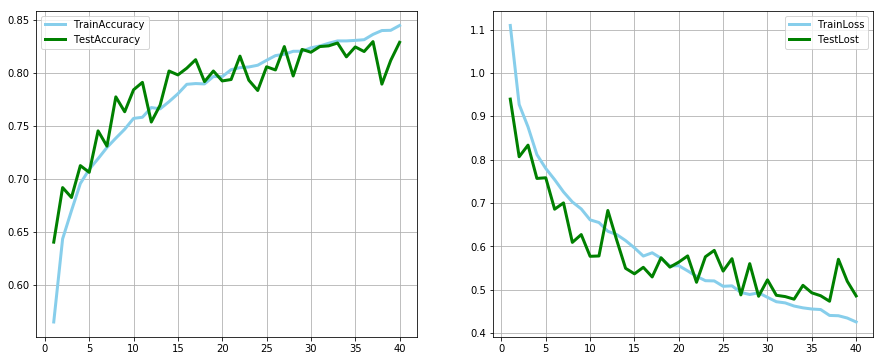

In [28]:
df = pd.read_csv(results)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.grid(True)
plt.plot( 'epoch', 'TrainAccuracy', data=df, marker='',color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestAccuracy', data=df, marker='', color='green', linewidth=3)
plt.legend()
plt.subplot(1,2,2)
plt.plot( 'epoch', 'TrainLoss', data=df, marker='', color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestLost', data=df, marker='', color='green', linewidth=3)
plt.grid(True)
plt.legend()
plt.show()

Step-2

- Notice that the highest accuracies are achieved after 30th epoch but they are improving very slowly. Now lets add two dropout layers to force the model to learn better and we will train 60 epochs. As we can see from the results, we improved the accuracy almost 1%. This may seem small but it corresonds to 14000*0.01=140 more correctly predicted images since we have 14000 images in the test set.

In [12]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=60 ,runtotal=1)

In [13]:
results  = 'CNN2019-08-18_time_09-10.csv'
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLoss,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
47,1.0,48.0,0.4621,0.8301,0.4503,0.8353,0.0003,32.0,0.0,30.4419
51,1.0,52.0,0.4567,0.8329,0.4501,0.8350,0.0003,32.0,0.0,30.0813
59,1.0,60.0,0.4330,0.8387,0.4499,0.8347,0.0003,32.0,0.0,30.1068
55,1.0,56.0,0.4374,0.8370,0.4549,0.8333,0.0003,32.0,0.0,30.2600
48,1.0,49.0,0.4640,0.8313,0.4512,0.8297,0.0003,32.0,0.0,30.0189


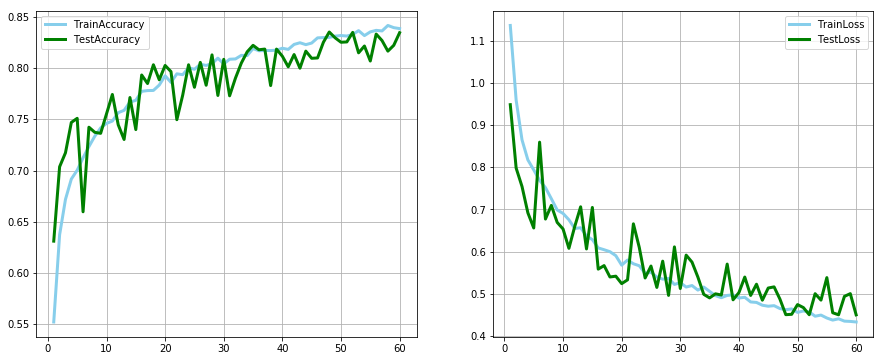

In [13]:
df = pd.read_csv(results)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.grid(True)
plt.plot( 'epoch', 'TrainAccuracy', data=df, marker='',color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestAccuracy', data=df, marker='', color='green', linewidth=3)
plt.legend()
plt.subplot(1,2,2)
plt.plot( 'epoch', 'TrainLoss', data=df, marker='', color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestLoss', data=df, marker='', color='green', linewidth=3)
plt.grid(True)
plt.legend()
plt.show()

Step-3 

- Now we will double the number of feature maps in each convolutional layer with the same parameters and train 100 epochs. Combined with the dropout above, we remarkably improved the accuracy about %3 as we can see the results below. The effect of convolutional layers should be appreciated in this sense. 
- Notice that after we achived %86 accuracy around 67th epoch, the model does not show a significicent improvement.

In [16]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=100 ,runtotal=1)

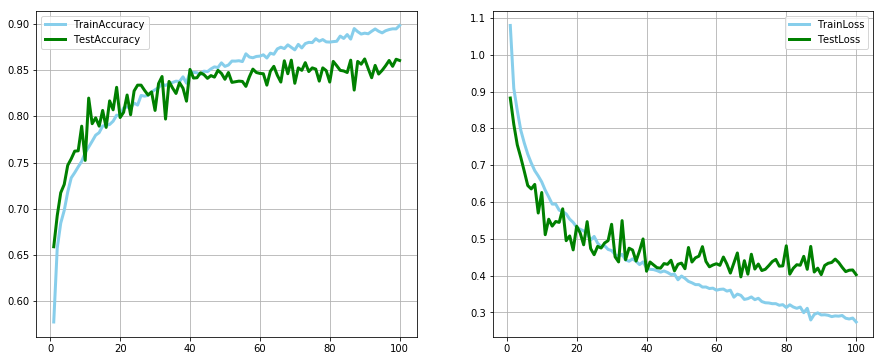

In [17]:
results = 'CNN2019-08-18_time_10-27.csv' 
df = pd.read_csv(results)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.grid(True)
plt.plot( 'epoch', 'TrainAccuracy', data=df, marker='',color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestAccuracy', data=df, marker='', color='green', linewidth=3)
plt.legend()
plt.subplot(1,2,2)
plt.plot( 'epoch', 'TrainLoss', data=df, marker='', color='skyblue', linewidth=3)
plt.plot( 'epoch', 'TestLoss', data=df, marker='', color='green', linewidth=3)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
GetBestAcc(results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLoss,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
89,1.0,90.0,0.2933,0.8898,0.4027,0.8620,0.0003,32.0,0.0,44.2493
98,1.0,99.0,0.2848,0.8945,0.4154,0.8617,0.0003,32.0,0.0,39.9687
85,1.0,86.0,0.3113,0.8834,0.4172,0.8607,0.0003,32.0,0.0,39.2114
68,1.0,69.0,0.3375,0.8745,0.4040,0.8607,0.0003,32.0,0.0,39.1022
96,1.0,97.0,0.2843,0.8938,0.4110,0.8603,0.0003,32.0,0.0,39.6951


Step-4
- Since we observe an improvement in inreasing the number of feature maps. Let's set the numbers as in description at the very beginning with dropout p=0.6. We made a small improvement as the top five accuracies are higher than before. Lets save the model.

In [13]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=100 ,runtotal=1)

In [15]:
final_results = 'CNN2019-08-19_time_00-50.csv'
GetBestAcc(final_results,5)

,run,epoch,TrainLoss,TrainAccuracy,TestLoss,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
95,1.0,96.0,0.2565,0.9057,0.4019,0.8663,0.0003,32.0,0.0,57.9459
94,1.0,95.0,0.2535,0.9056,0.4036,0.8630,0.0003,32.0,0.0,57.9753
80,1.0,81.0,0.2775,0.8983,0.3925,0.8617,0.0003,32.0,0.0,58.1265
51,1.0,52.0,0.3502,0.8692,0.3933,0.8613,0.0003,32.0,0.0,58.3125
86,1.0,87.0,0.2604,0.9013,0.3992,0.8610,0.0003,32.0,0.0,58.2967


In [19]:
save_checkpoint(opt_model,'CNN_86_6',final_results)

We have now a pretrained model in our hand with the testing accuracy 86.6. One can load and work on it to further improve. Here is the final structure. 

In [79]:
model = load_checkpoint('/home/erdideniz28/MyDnnLibrary/IntelImageKernels/CNN_86_6.pth')
model

Network(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=576, out_features=4000, bias=True)
  (bn5): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.6)
  (fc2): Linear(in_features=4000, out_features=4000, bias=True)
  (bn6): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.6)
  (fc3): Linear(in_features=4000, out_features=1000, bias=True)
  (bn7): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_f

we can also look at the best scores achived at the final stage.

In [80]:
model.best_scores

{'max_epoch_num': 100.0,
 'BestTrainLoss': 0.23582390985360455,
 'BestTrainAccuracy': 0.9144933732449202,
 'BestTestLoss': 0.3878039377133052,
 'BestTestAccuracy': 0.866333333492279,
 'lr': 0.0003,
 'batch_size': 32,
 'weight_decay': 0.0}

Just for illusturation purposes, lets work on this pretrained model a few more epochs. We should start with the testing accuracy around %85. Note that we turn on grad_requires = True in the main code.

In [88]:
HyperParameters = dict(
    lr = [3e-4],
    batch_size = [32],
    weight_decay = [0.0],
)
filename = GetFilename()+'.csv'
param_values = [v for v in HyperParameters.values()]
opt_model = StartTrain(num_epochs=10 ,runtotal=1)

,run,epoch,TrainLoss,TrainAccuracy,TestLoss,TestAccuracy,lr,batch_size,weight_decay,epoch_duration
0,1.0,1.0,0.2396,0.9130,0.4212,0.8660,0.0003,32.0,0.0,58.4698
1,1.0,2.0,0.2382,0.9111,0.4251,0.8603,0.0003,32.0,0.0,58.7638
2,1.0,3.0,0.2371,0.9134,0.4199,0.8620,0.0003,32.0,0.0,58.9583
3,1.0,4.0,0.2368,0.9104,0.4190,0.8623,0.0003,32.0,0.0,59.0744
4,1.0,5.0,0.2297,0.9147,0.4444,0.8583,0.0003,32.0,0.0,59.1063
5,1.0,6.0,0.2330,0.9139,0.4396,0.8643,0.0003,32.0,0.0,59.1348
6,1.0,7.0,0.2325,0.9166,0.4206,0.8593,0.0003,32.0,0.0,59.0222
7,1.0,8.0,0.2268,0.9119,0.4317,0.8597,0.0003,32.0,0.0,59.0386
8,1.0,9.0,0.2278,0.9160,0.5065,0.8433,0.0003,32.0,0.0,58.8053
9,1.0,10.0,0.2239,0.9143,0.4779,0.8503,0.0003,32.0,0.0,58.7487


Conclusion

- In this notebook, we tried to demostrate how to train a convolutional neural network from scracth. After a couple of hours, we reached a testing accuracy of %86.6. To go over this accracy, we should carefully tune the other parameters, maybe try a different optimizer and so spend more time on the model. We should note that although there is a strong theory behind neural networks, most of methods are driven by common heuristics tested before by the other practioners. We tried to describe some of them in this report. For example, we have seen above that adding new layers with dropout increased the accuracy around %4. Similarly if we turn on weight decay, we would see a dramatic decrease in training (so in testing) accuracies. These are what we know. But what we dont know is how and to which extend a model responds a certain change in its configuration. For example if we use a random affine transformation along with some blurring methods instead of the transformations above, we don't know whether the accuracy gets better or not. As some researcher point out, deep learning is in its infancy novadays.